## Crypto Trading Algorythm
The challenge with trying to predict a sell or a buy signal for any trading strategy is defined within the classification framework, where the predicted variable has a value of 0 for sell and 1 for buy. This signal is determined through the comparison of the short term and long term price trends of an assist.

We use data from the CBSE bitcoin exchange in terms of the volume-weighted average price (VWAP) which is a technical analysis indicator used on intraday charts that resets at the start of every new trading session. It's a trading benchmark that represents the average price a security has traded at throughout the day, based on both volume and price. VWAP is important because it provides traders with pricing insight into both the trend and value of a security. This data is pulled via an Alpaca API and the data covers prices from Oct 2016 to current day. Different trend and momentum indicators are created from the data and are added as features to enhance the performance of the prediction model.


## Load libraries and py packages


In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pathlib import Path
import os
import alpaca_trade_api as tradeapi
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
from IPython.html.widgets import interactive, fixed
from mpl_toolkits.mplot3d import Axes3D

## Import the BTC-USD dataset from Alpaca API into a Pandas DataFrame.

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [3]:
# Set the ticker
ticker = "BTCUSD"

# Set timeframe to "1Hour"
timeframe = "1Hour"

# Set start and end datetimes of 6 years from Today
start_date = pd.Timestamp("2016-10-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2023-11-3", tz="America/New_York").isoformat()

# Get 6 year's worth of historical data for BTC
ticker_data = api.get_crypto_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df

ticker_data

,exchange,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-10-31 04:00:00+00:00,CBSE,696.92,698.51,695.33,698.23,143.727019,355,696.393770
2016-10-31 05:00:00+00:00,CBSE,698.16,699.62,697.42,699.47,131.684069,302,698.574562
2016-10-31 06:00:00+00:00,CBSE,699.66,700.13,699.66,700.11,75.029052,145,699.992566
2016-10-31 07:00:00+00:00,CBSE,700.12,701.01,699.02,699.21,61.233099,219,699.998528
2016-10-31 08:00:00+00:00,CBSE,699.20,701.75,698.82,701.32,83.527852,257,700.836560
...,...,...,...,...,...,...,...,...
2022-11-10 21:00:00+00:00,ERSX,18018.20,18018.20,17721.40,17804.10,93.486238,764,17853.315686
2022-11-10 21:00:00+00:00,FTXU,17721.00,18100.00,17456.00,17772.00,79.247700,463,17841.710765
2022-11-10 22:00:00+00:00,CBSE,17803.37,17826.25,17622.71,17791.16,1353.289047,29726,17725.100254


## Data Prep and Cleaning

In [4]:
df = ticker_data

In [5]:
# view the dataframe shape
df.shape

(81843, 8)

In [6]:
# view data
df

,exchange,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-10-31 04:00:00+00:00,CBSE,696.92,698.51,695.33,698.23,143.727019,355,696.393770
2016-10-31 05:00:00+00:00,CBSE,698.16,699.62,697.42,699.47,131.684069,302,698.574562
2016-10-31 06:00:00+00:00,CBSE,699.66,700.13,699.66,700.11,75.029052,145,699.992566
2016-10-31 07:00:00+00:00,CBSE,700.12,701.01,699.02,699.21,61.233099,219,699.998528
2016-10-31 08:00:00+00:00,CBSE,699.20,701.75,698.82,701.32,83.527852,257,700.836560
...,...,...,...,...,...,...,...,...
2022-11-10 21:00:00+00:00,ERSX,18018.20,18018.20,17721.40,17804.10,93.486238,764,17853.315686
2022-11-10 21:00:00+00:00,FTXU,17721.00,18100.00,17456.00,17772.00,79.247700,463,17841.710765
2022-11-10 22:00:00+00:00,CBSE,17803.37,17826.25,17622.71,17791.16,1353.289047,29726,17725.100254


In [7]:
# describe data
df.describe()

,open,high,low,close,volume,trade_count,vwap
count,81843.000000,81843.000000,81843.000000,81843.000000,81843.000000,81843.000000,81843.000000
mean,23638.461046,23756.135814,23511.592540,23637.298501,424.127465,5278.402637,23634.485176
std,18434.986303,18524.332275,18338.365196,18433.595789,643.809750,9697.757668,18431.566396
min,0.060000,690.320000,0.060000,682.700000,0.000086,1.000000,685.332013
25%,7850.005000,7898.495000,7798.840000,7850.150000,33.270900,158.500000,7847.499428
50%,19314.000000,19375.000000,19245.000000,19313.000000,232.715400,1599.000000,19312.828281
75%,39670.570000,39839.395000,39469.000000,39673.000000,545.514934,4929.000000,39652.696090
max,68639.400000,69091.200000,68478.900000,68639.630000,16598.372341,192957.000000,68626.933075


In [8]:
#Checking for any null values and removing the null values'''
print('Null Values =',df.isnull().values.any())

Null Values = False


In [9]:
# We are only using data from the CBSE exchange
df = df[df['exchange'] == 'CBSE']
df

,exchange,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-10-31 04:00:00+00:00,CBSE,696.92,698.51,695.33,698.23,143.727019,355,696.393770
2016-10-31 05:00:00+00:00,CBSE,698.16,699.62,697.42,699.47,131.684069,302,698.574562
2016-10-31 06:00:00+00:00,CBSE,699.66,700.13,699.66,700.11,75.029052,145,699.992566
2016-10-31 07:00:00+00:00,CBSE,700.12,701.01,699.02,699.21,61.233099,219,699.998528
2016-10-31 08:00:00+00:00,CBSE,699.20,701.75,698.82,701.32,83.527852,257,700.836560
...,...,...,...,...,...,...,...,...
2022-11-10 18:00:00+00:00,CBSE,17176.16,17457.32,17161.19,17340.27,1650.320314,50757,17304.196386
2022-11-10 19:00:00+00:00,CBSE,17340.10,17475.26,17202.94,17429.96,1775.918029,45275,17349.631676
2022-11-10 20:00:00+00:00,CBSE,17431.44,18140.62,17339.61,18047.58,3661.739337,57982,17658.050798


In [10]:
# The exchange column is not useful for modeling and is dropped from the dataset
df=df.drop(columns=['exchange'])
df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2016-10-31 04:00:00+00:00,696.92,698.51,695.33,698.23,143.727019,355,696.393770
2016-10-31 05:00:00+00:00,698.16,699.62,697.42,699.47,131.684069,302,698.574562
2016-10-31 06:00:00+00:00,699.66,700.13,699.66,700.11,75.029052,145,699.992566
2016-10-31 07:00:00+00:00,700.12,701.01,699.02,699.21,61.233099,219,699.998528
2016-10-31 08:00:00+00:00,699.20,701.75,698.82,701.32,83.527852,257,700.836560
...,...,...,...,...,...,...,...
2022-11-10 18:00:00+00:00,17176.16,17457.32,17161.19,17340.27,1650.320314,50757,17304.196386
2022-11-10 19:00:00+00:00,17340.10,17475.26,17202.94,17429.96,1775.918029,45275,17349.631676
2022-11-10 20:00:00+00:00,17431.44,18140.62,17339.61,18047.58,3661.739337,57982,17658.050798


## Generate trading signals using short and long window SMA values. 
Create the target variable for our model. This is the column that will indicate whether the trading signal is buy or sell. We define the short-term price as the 10-day rolling average and the longterm price as the 60-day rolling average.

In [11]:
# Preping Data
# Build signals 1 for buy and 0 for sell. 
# 1 signals short term will go up in comparison to the long term price of bitcoin.
# 0 signals short term will go down in comparison to the long term price of bitcoin.

# calculating short simple moving average over a 10 day window
df['short_moving_average'] = df['close'].rolling(window=10, min_periods=1, center=False).mean()

# calculating long simple moving average over a 60 day window
df['long_moving_average'] = df['close'].rolling(window=60, min_periods=1, center=False).mean()

# generating the signals
df['signal'] = np.where(df['short_moving_average'] > df['long_moving_average'], 1.0, 0.0)

In [12]:
df.tail(500)

,open,high,low,close,volume,trade_count,vwap,short_moving_average,long_moving_average,signal
timestamp,,,,,,,,,,
2022-10-21 03:00:00+00:00,19108.38,19125.35,19044.20,19051.92,344.958139,17310,19089.786959,19057.699,19180.633667,0.0
2022-10-21 04:00:00+00:00,19051.91,19081.25,19026.05,19047.32,390.578274,17445,19052.180681,19056.463,19174.556167,0.0
2022-10-21 05:00:00+00:00,19047.72,19065.86,19028.21,19044.78,299.721263,15638,19048.210110,19054.619,19168.510333,0.0
2022-10-21 06:00:00+00:00,19043.53,19072.23,19027.83,19035.89,374.636493,16376,19046.194409,19055.155,19165.418500,0.0
2022-10-21 07:00:00+00:00,19035.93,19082.16,18990.07,19027.04,729.119372,22674,19037.606954,19050.507,19162.197333,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-11-10 18:00:00+00:00,17176.16,17457.32,17161.19,17340.27,1650.320314,50757,17304.196386,17054.293,17741.219333,0.0
2022-11-10 19:00:00+00:00,17340.10,17475.26,17202.94,17429.96,1775.918029,45275,17349.631676,17134.962,17701.687000,0.0
2022-11-10 20:00:00+00:00,17431.44,18140.62,17339.61,18047.58,3661.739337,57982,17658.050798,17309.573,17673.560167,0.0


In [13]:
df.shape

(52638, 10)

## Feature Engineering
Feature engineering is the ‘art’ of formulating useful features from existing data following the target to be learned and the machine learning model used. It involves transforming data to forms that better relate to the underlying target to be learned. We begin by analyzing the features that we expect may influence the performance of our prediction model. Based on a conceptual understanding of key factors that drive investment strategies, the task at hand is to identify and construct new features that may capture the risks or characteristics embodied by these return drivers.

The current dataset of the bitcoin (BTC) consists of timestamp, open, high, low, close, volume, trade count and vwap. Using this data, we calculate the following momentum indicators.

We perform feature engineering to construct technical indicators which will be used to make the predictions, and the output variable.

##### Relative Strength Index(RSI):
Is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.

The RSI is calculated using the following formula: RSI = 100 – (100 / [1 + RSI]), where RSI equals the average gains of up periods during the specified period divided by the average losses of down periods during the specified period.

When using the RSI, traders look for the following:

- Buying opportunities at oversold positions (when the RSI value is 30 and below)
- Buying opportunities in a bullish trend (when the RSi is above 50 but below 70)
- Buying opportunities during a bullish reversal (in a bullish divergence)
- Selling opportunities at overbought positions (when the RSI value is 70 and above)
- Selling opportunities in a bearish trend (when the RSI value is below 50 but above 30)
- Selling opportunities during a bearish reversal (in a bearish divergence)

In [14]:
#calculate the relative strength index

def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
df['RSI10'] = RSI(df['close'], 10)
df['RSI30'] = RSI(df['close'], 30)
df['RSI200'] = RSI(df['close'], 200)


<AxesSubplot:xlabel='timestamp'>

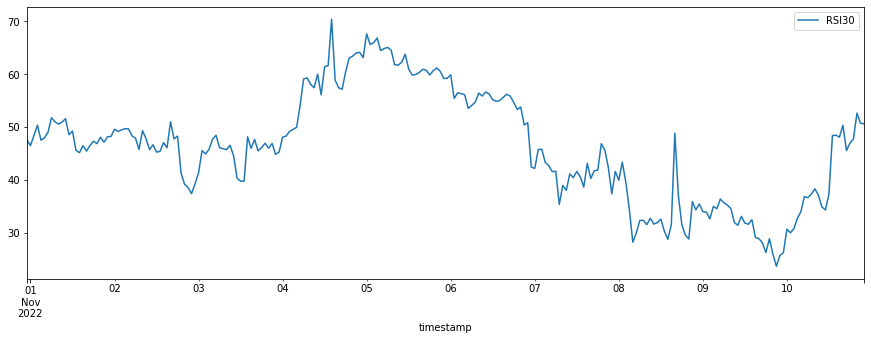

In [15]:
#Data Visualization
df[['RSI30']].iloc[-240:,:].plot(figsize= (15,5))

##### Rate Of Change(ROC): 
It is a momentum oscillator, which measures the percentage change between the current price with respect to an earlier closing price n periods ago.

How this indicator works
- An upward surge in the Rate-of-Change reflects a sharp price advance. A downward plunge indicates a steep price decline.
- In general, prices are rising as long as the Rate-of-Change remains positive. Conversely, prices are falling when the Rate-of-Change is negative.
- ROC expands into positive territory as an advance accelerates. ROC moves deeper into negative territory as a decline accelerates.

Calculation

ROC = [(Today’s Closing Price – Closing Price n periods ago) / Closing Price n periods ago] x 100

In [16]:
#calculate the rate of change

def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
df['ROC10'] = ROC(df['close'], 10)
df['ROC30'] = ROC(df['close'], 30)


<AxesSubplot:xlabel='timestamp'>

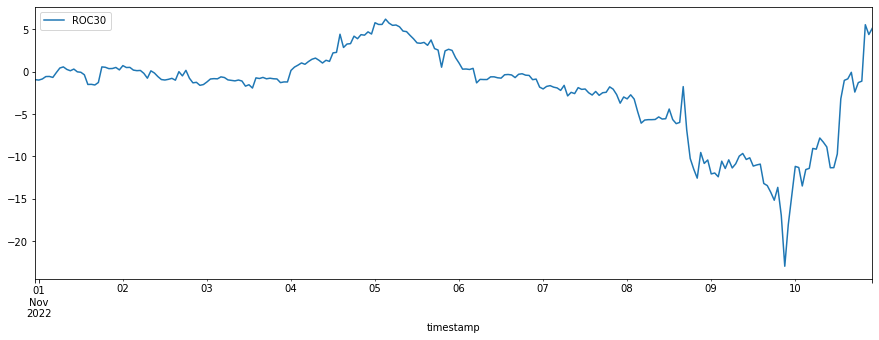

In [17]:
#Data Visualization
df[['ROC30']].iloc[-240:,:].plot(figsize= (15,5))

##### Momentum (MOM):
The Momentum Oscillator measures the amount that a security’s price has changed over a given period of time. The Momentum Oscillator is the current price divided by the price of a previous period, and the quotient is multiplied by 100. The result is an indicator that oscillates around 100. Values less than 100 indicate negative momentum, or decreasing price, and vice versa.

Calculation

Momentum Oscillator = (Price today / Price n periods ago) x 100

In [18]:
#calculate the price momentum

def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
df['MOM10'] = MOM(df['close'],10)
df['MOM30'] = MOM(df['close'],30)


<AxesSubplot:xlabel='timestamp'>

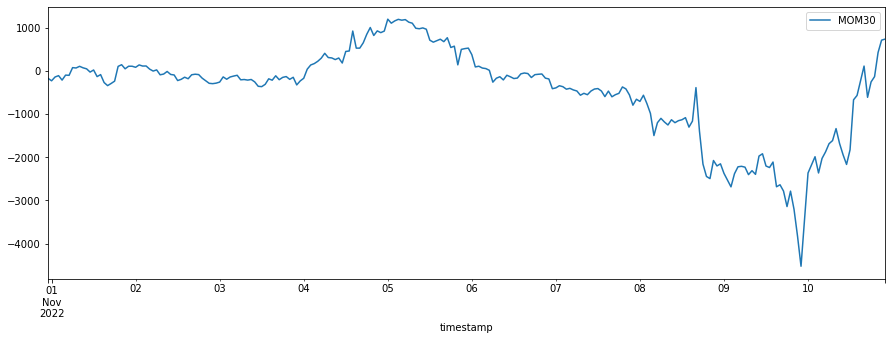

In [19]:
#Data Visualization
df[['MOM30']].iloc[-240:,:].plot(figsize= (15,5))

##### Stochastic Oscillator %K and %D: 
A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. 

Stochastic oscillators measure recent prices on a scale of 0 to 100, with measurements above 80 indicating that an asset is overbought and measurements below 20 indicating that it is oversold.


In [21]:
#calculate the Stochastic Oscillator %K and %D.

def SOK(close, low, high, n): 
 SOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return SOK

def SOD(close, low, high, n):
 SOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 SOD = SOK.rolling(3).mean()
 return SOD

df['%K10'] = SOK(df['close'], df['low'], df['high'], 10)
df['%D10'] = SOD(df['close'], df['low'], df['high'], 10)
df['%K30'] = SOK(df['close'], df['low'], df['high'], 30)
df['%D30'] = SOD(df['close'], df['low'], df['high'], 30)
df['%K200'] = SOK(df['close'], df['low'], df['high'], 200)
df['%D200'] = SOD(df['close'], df['low'], df['high'], 200)

<AxesSubplot:xlabel='timestamp'>

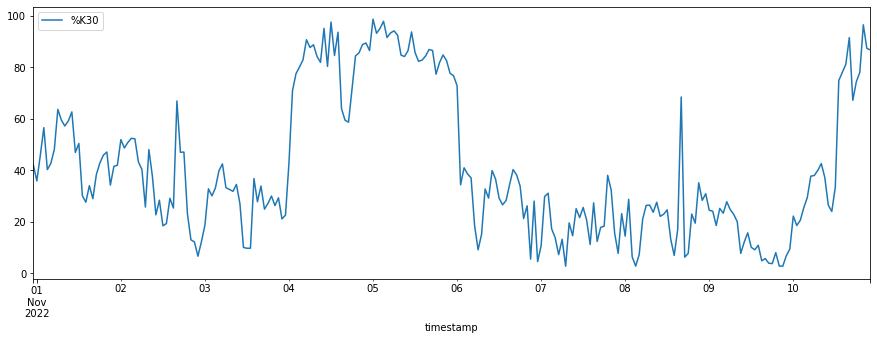

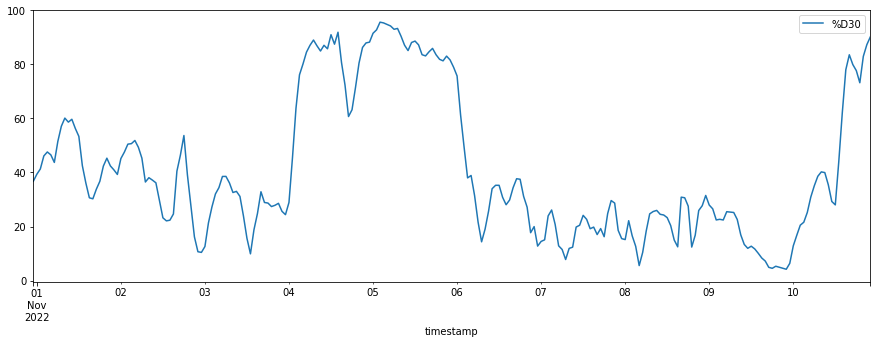

In [22]:
#Data Visualization
df[['%K30']].iloc[-240:,:].plot(figsize= (15,5))

#Data Visualization
df[['%D30']].iloc[-240:,:].plot(figsize= (15,5))


##### Exponential Moving Average (EMA)
Exponential Moving Average (EMA) is similar to Simple Moving Average (SMA), measuring trend direction over a period of time. However, whereas SMA simply calculates an average of price data, EMA applies more weight to data that is more current. Because of its unique calculation, EMA will follow prices more closely than a corresponding SMA.


In [23]:
#calculate the exponential moving average

def EX_MA(df, n):
    EX_MA = pd.Series(df['close'].ewm(span = n, min_periods = n).mean(), name = 'EX_MA_' + str(n))
    return EX_MA
df['EX_MA10'] = EX_MA(df,10)
df['EX_MA30'] = EX_MA(df,30)
df['EX_MA200'] = EX_MA(df,200)


<AxesSubplot:xlabel='timestamp'>

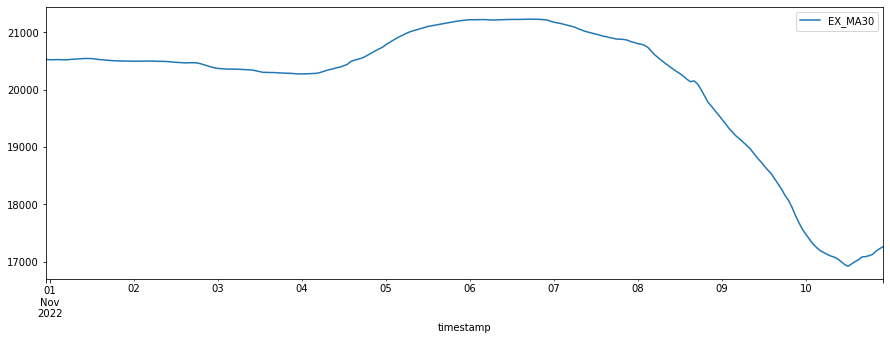

In [24]:
#Data Visualization
df[['EX_MA30']].iloc[-240:,:].plot(figsize= (15,5))


##### Moving Average: 
A moving average provides an indication of the trend of the price movement by cut down the amount of "noise" on a price chart.

- The moving average helps to level the price data over a specified period by creating a constantly updated average price.
- A simple moving average (SMA) is a calculation that takes the arithmetic mean of a given set of prices over a specific number of days in the past.

In [25]:
#Calculate the moving average

def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
df['MA10'] = MA(df,10)
df['MA30'] = MA(df,30)
df['MA200'] = MA(df,200)


<AxesSubplot:xlabel='timestamp'>

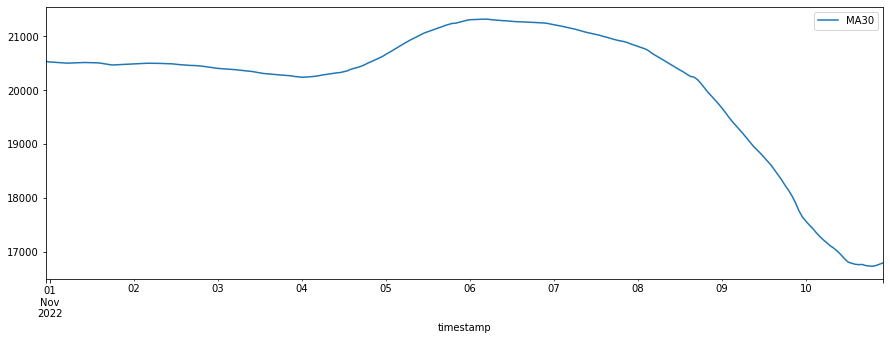

In [26]:
#Data Visualization
df[['MA30']].iloc[-240:,:].plot(figsize= (15,5))

In [27]:
# view the updated dataframe shape
df.shape

(52638, 29)

In [28]:
# view the updated dataset with the new indicators
df.tail()

,open,high,low,close,volume,trade_count,vwap,short_moving_average,long_moving_average,signal,...,%K30,%D30,%K200,%D200,EX_MA10,EX_MA30,EX_MA200,MA10,MA30,MA200
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-11-10 18:00:00+00:00,17176.16,17457.32,17161.19,17340.27,1650.320314,50757,17304.196386,17054.293,17741.219333,0.0,...,74.379180,77.685388,30.640712,32.171404,17156.984487,17103.759260,19290.969369,17054.293,16730.449667,19863.73085
2022-11-10 19:00:00+00:00,17340.10,17475.26,17202.94,17429.96,1775.918029,45275,17349.631676,17134.962,17701.687000,0.0,...,78.028022,73.196600,32.143863,30.224967,17206.616398,17124.804469,19272.451863,17134.962,16725.962333,19848.73000
2022-11-10 20:00:00+00:00,17431.44,18140.62,17339.61,18047.58,3661.739337,57982,17658.050798,17309.573,17673.560167,0.0,...,96.460500,82.955901,42.494805,35.093126,17359.518871,17184.338375,19260.264084,17309.573,16740.066000,19836.99830
2022-11-10 21:00:00+00:00,18048.82,18111.01,17710.71,17807.22,3478.106987,65935,17889.326226,17468.521,17640.673833,0.0,...,87.316539,87.268354,38.466515,37.701727,17440.919077,17224.524286,19245.805933,17468.521,16763.718333,19824.04885
2022-11-10 22:00:00+00:00,17803.37,17826.25,17622.71,17791.16,1353.289047,29726,17725.100254,17601.631,17608.961000,0.0,...,86.705572,90.160870,38.197359,39.719559,17504.599244,17261.081429,19231.331845,17601.631,16788.178000,19810.84045


In [29]:
# exclude the columns that are not needed for our prediction.
df = df.drop(['high','low','open','short_moving_average','long_moving_average'], axis=1)
df = df.dropna(axis=0)
df.tail()

,close,volume,trade_count,vwap,signal,RSI10,RSI30,RSI200,ROC10,ROC30,...,%K30,%D30,%K200,%D200,EX_MA10,EX_MA30,EX_MA200,MA10,MA30,MA200
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-11-10 18:00:00+00:00,17340.27,1650.320314,50757,17304.196386,0.0,57.192623,46.958923,44.099296,4.313231,-1.277059,...,74.379180,77.685388,30.640712,32.171404,17156.984487,17103.759260,19290.969369,17054.293,16730.449667,19863.73085
2022-11-10 19:00:00+00:00,17429.96,1775.918029,45275,17349.631676,0.0,58.813811,47.731018,44.347294,6.922627,-1.103636,...,78.028022,73.196600,32.143863,30.224967,17206.616398,17124.804469,19272.451863,17134.962,16725.962333,19848.73000
2022-11-10 20:00:00+00:00,18047.58,3661.739337,57982,17658.050798,0.0,68.066966,52.641841,46.005115,11.282953,5.555910,...,96.460500,82.955901,42.494805,35.093126,17359.518871,17184.338375,19260.264084,17309.573,16740.066000,19836.99830
2022-11-10 21:00:00+00:00,17807.22,3478.106987,65935,17889.326226,0.0,62.039879,50.723254,45.475275,8.184417,4.396047,...,87.316539,87.268354,38.466515,37.701727,17440.919077,17224.524286,19245.805933,17468.521,16763.718333,19824.04885
2022-11-10 22:00:00+00:00,17791.16,1353.289047,29726,17725.100254,0.0,61.634709,50.595795,45.440132,1.333309,5.139192,...,86.705572,90.160870,38.197359,39.719559,17504.599244,17261.081429,19231.331845,17601.631,16788.178000,19810.84045


In [30]:
# view the updated dataframe shape
df.shape

(52437, 24)

## Data Visualization
Visualize different properties of the features and the predicted variable

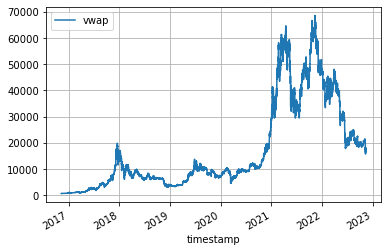

In [31]:
#Data Visualization
df[['vwap']].plot(grid=True)
plt.show()

##### The chart illustrates a sharp rise in the price of bitcoin to a steep drop, increasing from under 1000 to a high of almost $70,000 at the end of 2021. Also, high price volatility is readily visible.

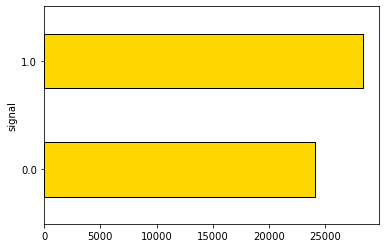

In [32]:
#Data Visualization
fig = plt.figure()
plot = df.groupby(['signal']).size().plot(kind='barh', color='gold', edgecolor='black')
plt.show()

##### The predicted variable signal shows us the amount of times a signal is either a BUY or SELL, the predicted variable is relatively balanced however.

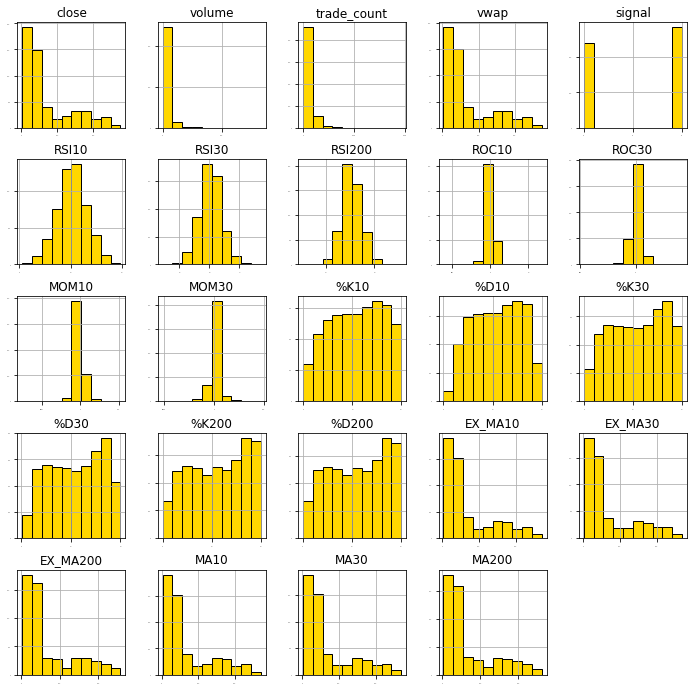

In [33]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12), color='gold',edgecolor='black')
plt.show()

##### This histogram summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the major features of the distribution of the data in a convenient form.

<AxesSubplot:title={'center':'Correlation Matrix'}>

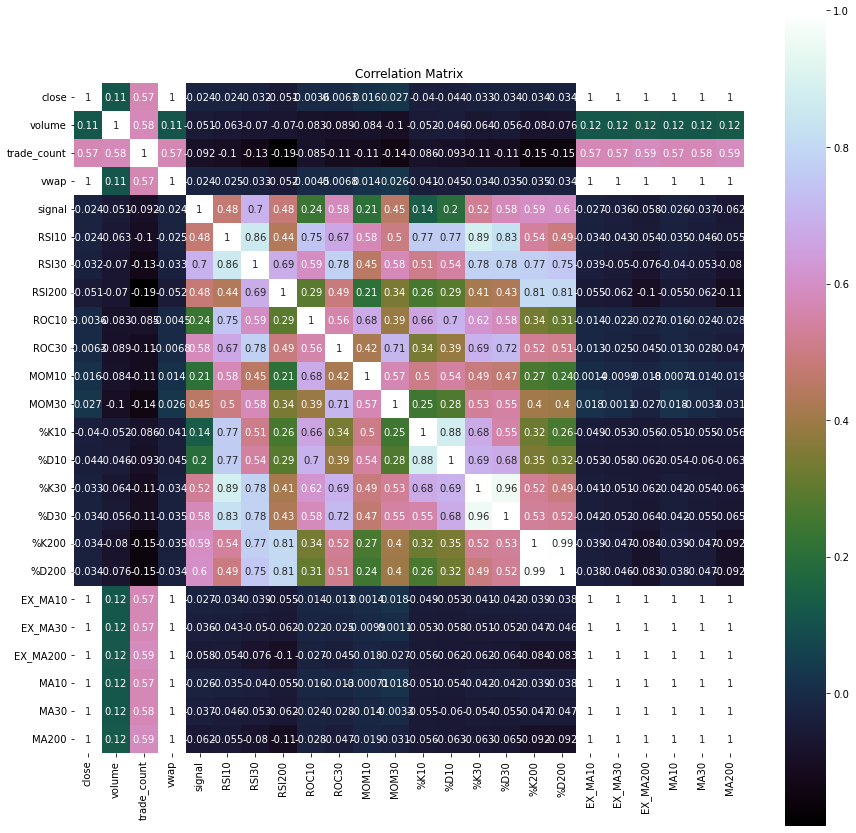

In [34]:
# correlation
correlation = df.corr()
plt.figure(figsize = (15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax = 1, square = True, annot = True, cmap = 'cubehelix')

##### This correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.

## Train Test Split
Split the dataset into 80% training set and 20% test set.

In [35]:
# split out validation dataset for the end
validation_df= df.iloc[-10000:]
Y= validation_df["signal"]
X = validation_df.loc[:, df.columns != 'signal']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [36]:
# test options for classification
number_folds = 10
seed = 7
scoring = 'accuracy'

## Algo and Model Comparisons
In order to know which algorithm is best for our strategy, we evaluate the linear, nonlinear, and ensemble models.

In [37]:
# Verifying the most accurate models
ml_model = []
ml_model.append(('NB', GaussianNB()))
ml_model.append(('LR', LogisticRegression(n_jobs=-1)))
ml_model.append(('CART', DecisionTreeClassifier()))
ml_model.append(('LDA', LinearDiscriminantAnalysis()))
ml_model.append(('KNN', KNeighborsClassifier()))
ml_model.append(('NN', MLPClassifier()))
ml_model.append(('AB', AdaBoostClassifier()))
ml_model.append(('GBM', GradientBoostingClassifier()))
ml_model.append(('RF', RandomForestClassifier(n_jobs=-1)))


### K-folds cross validation
Helps us to avoid overfitting. As we know when a model is trained using all of the data in a single short and give the best performance accuracy. To resist this k-fold cross-validation helps us to build the model is a generalized one

In [38]:
results = []
names = []
for name, ml_model in ml_model:
    kfold = KFold(n_splits = number_folds)
    cv_results = cross_val_score(ml_model, X_train, Y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NB: 0.810250 (0.014703)
LR: 0.907625 (0.013008)
CART: 0.897000 (0.011308)
LDA: 0.913750 (0.012042)
KNN: 0.851500 (0.010455)
NN: 0.813625 (0.055774)
AB: 0.914000 (0.008437)
GBM: 0.921750 (0.009138)
RF: 0.938375 (0.006150)


### Vizualize and Compare algorithms


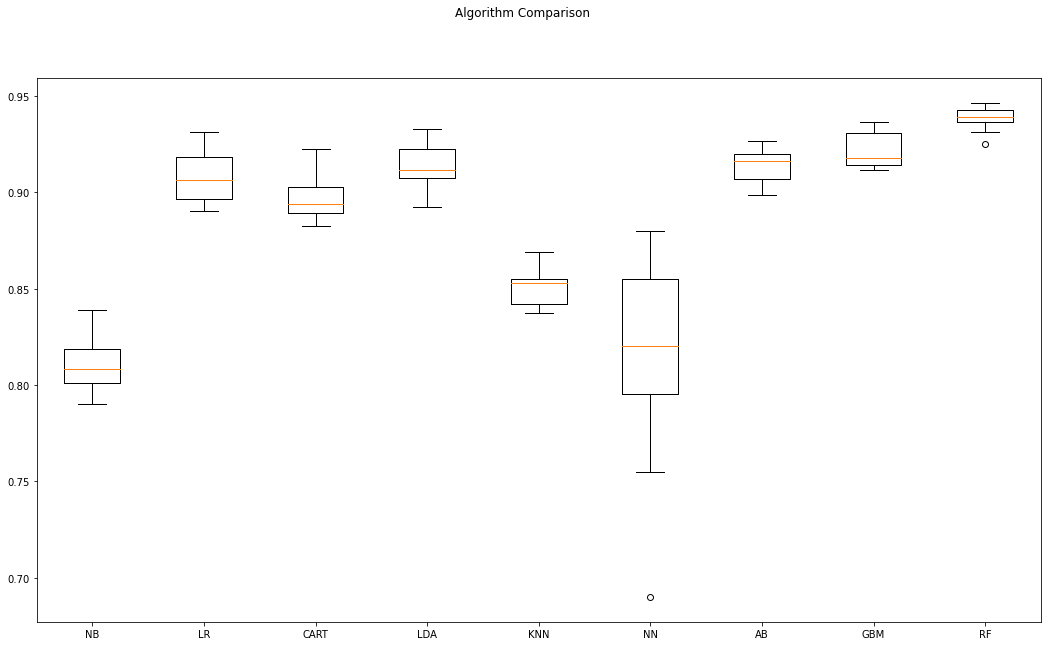

In [39]:
# compare algorithms visually using box and whisker plots
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(18,10)
plt.show()

##### After performing the k-fold cross validation, the Alogorithm comp chart illustrates the comparison of the models.

## Model Tuning
Although some of the models show promising results, we prefer an ensemble model given the size of the dataset, the large number of features, and an expected non‐linear relationship between the predicted variable and the features. Random forest has the best performance among the ensemble models

Random Forests are often used for feature selection in a data science workflow. The reason is because the tree-based strategies used by random forests naturally ranks by how well they improve the purity of the node. This mean decrease in impurity over all trees (called gini impurity).

### Random Forest Classifier
number_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables    

criterion : string, optional (default=”gini”)
    The function to measure the quality of a split. 
    Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

The range of Entropy lies in between 0 to 1 and the range of Gini Impurity lies in between 0 to 0.5. 
Hence we can conclude that Gini Impurity is better as compared to entropy for selecting the best features.

In [40]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
number_estimators = [20,80]
maximum_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators = number_estimators, max_depth = maximum_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits = number_folds)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)
# Peek at results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.931125 using {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}
#7 0.894125 (0.013206) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#6 0.895000 (0.013829) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#3 0.927375 (0.007875) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#2 0.929000 (0.005750) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.893875 (0.011187) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.897125 (0.013636) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#4 0.927000 (0.011446) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.931125 (0.008167) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


## Finalize the Model
Finalizing the model with best parameters found during tuning step.

### Test Dataset results

In [42]:
# prepare the model
rf_model = RandomForestClassifier(criterion = 'gini', n_estimators = 80, max_depth = 10, n_jobs = -1)
rf_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [43]:
# estimate accuracy on validation set
predictions = rf_model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9275
[[997  76]
 [ 69 858]]
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      1073
         1.0       0.92      0.93      0.92       927

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



##### The selected model performs quite well, with a high accuracy.
1. Precision: Percentage of correct positive predictions relative to total positive predictions.
2. Recall: Percentage of correct positive predictions relative to total actual positives.
3. F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

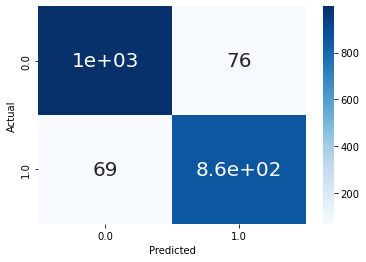

In [45]:
# confusion matrix
df_confusion = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns = np.unique(Y_validation), index = np.unique(Y_validation))
df_confusion.index.name = 'Actual'
df_confusion.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot = True, annot_kws = {"size": 20})

##### The overall model performance is reasonable and is in line with the training set results
Here we see the true positive, true negative, false positive and false negative values mean.

## Variable Intuition/Feature Importance

Text(0.5, 0, 'Variable Importance')

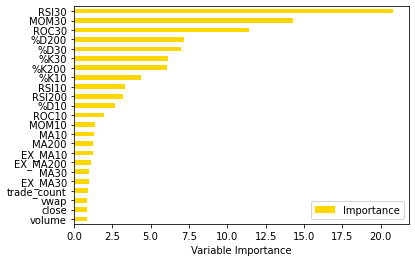

In [46]:
Importance = pd.DataFrame({'Importance':rf_model.feature_importances_ * 100}, index = X.columns)
Importance.sort_values('Importance', axis = 0, ascending = True).plot(kind = 'barh', color = 'gold' )
plt.xlabel('Variable Importance')

##### The result of the variable importance looks intuitive, and the momentum indicators of RSI, MOM and ROC over the last 30 days seem to be the three most important features. The feature importance chart corroborates the fact that introducing new features leads to an improvement in the model performance.

## Backtesting 
We perform a backtest on the model we’ve developed by creating a column for our daily returns and multiplying it by the strategy returns in relation to the position that was held at the close of business the previous day and then we compare it to the the actual returns.

<AxesSubplot:>

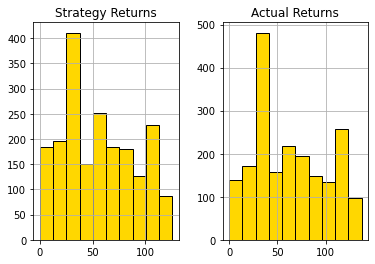

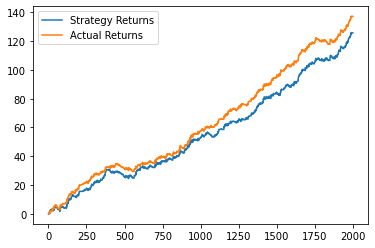

In [47]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
bt_data = pd.DataFrame(index = X_validation.index)
#bt_data = pd.DataFrame()
bt_data['signal_pred'] = predictions
bt_data['signal_actual'] = Y_validation
bt_data['Market Returns'] = X_validation['close'].pct_change()
bt_data['Actual Returns'] = bt_data['Market Returns'] * bt_data['signal_actual'].shift(1)
bt_data['Strategy Returns'] = bt_data['Market Returns'] * bt_data['signal_pred'].shift(1)
bt_data=bt_data.reset_index()
bt_data.head()
bt_data[['Strategy Returns','Actual Returns']].cumsum().hist(color = 'gold', edgecolor = 'black')
bt_data[['Strategy Returns','Actual Returns']].cumsum().plot()

##### When we look at our backtesting results, we can see that there is not much deviation from the actual market return. we can conclude that our momentum trading strategy in fact made us better at predicting the price direction to either sell or buy in order to achieve profits. We also made only a few losses in comparison to the actual returns.

## Buy or Sell
Algo model recommendations for the past 24 hours.

In [49]:
# exclude the columns other than date and signal call
df_sig = df.drop(['close','volume','trade_count','vwap','RSI10','RSI30','RSI200','ROC10','ROC30','MOM10','MOM30','EX_MA10','EX_MA30','EX_MA200','%K10','%D10','%K30','%D30','%K200','%D200','MA10','MA30','MA200'], axis=1)
df_sig = df_sig.dropna(axis=0)
df_sig.tail(24)


,signal
timestamp,
2022-11-09 23:00:00+00:00,0.0
2022-11-10 00:00:00+00:00,0.0
2022-11-10 01:00:00+00:00,0.0
2022-11-10 02:00:00+00:00,0.0
2022-11-10 03:00:00+00:00,0.0
2022-11-10 04:00:00+00:00,0.0
2022-11-10 05:00:00+00:00,0.0
2022-11-10 06:00:00+00:00,0.0
2022-11-10 07:00:00+00:00,0.0


#### Our Conclusions
One of the most significant steps in order to solve any problem, especially the hard and challenging ones, lies in finding a proper strategic approach and securing a complete understanding of the problem that we are trying to solve. A proper strategy approach should answer questions such as: should we have to predict prices, price movement direction, price trends, price spikes and so on.

Next, we apply data preprocessing and feature engineering strategies and outline that feature engineering is an effective method for the creation of intuitive features related to momentum and trend indicators of Bitcoin’s price movement and increases the accuracy of our models predictions.

In terms of the evaluation metrics for a classification-based trading strategy, accuracy is appropriate. However, in case the strategy is focusing to be more accurate while going long, the metric recall that focuses on less false positives can be preferred as compared to accuracy.

Then we demonstrated our back testing framework which allowed us to simulate a crypto trading strategy by using historical data to generate results and analyze risk and profitability before risking any actual capital.

Finally, we print out a Buy or Sell slip covering the previous 24 hour period with 1 representing a BUY recommendation and a 0 representing a SELL recommendation.

# Optional
#### Evaluating the Algorithms and Models 


#### Data Standardisation
As a preprocessing step, let's start with normalizing the feature values so they standardised - this makes comparisons simpler and allows next steps for Singular Value Decomposition

In [50]:
# Data Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
scaled_df = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns, index = X_train.index)
# summarize transformed data
X_train.dropna(how='any', inplace=True)
scaled_df.dropna(how='any', inplace=True)
scaled_df.head(2)

,close,volume,trade_count,vwap,RSI10,RSI30,RSI200,ROC10,ROC30,MOM10,...,%K30,%D30,%K200,%D200,EX_MA10,EX_MA30,EX_MA200,MA10,MA30,MA200
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-09 15:00:00+00:00,0.398268,-0.302610,-0.161154,0.390530,-0.086346,-0.324724,-1.223237,-0.255768,-0.130120,-0.141492,...,0.420127,0.274361,-1.123068,-1.166514,0.400102,0.403217,0.565340,0.401248,0.397321,0.604329
2022-04-21 21:00:00+00:00,0.334721,-0.168251,0.335805,0.336392,-1.462972,-0.693532,-0.259750,-2.106314,-0.358105,-1.978390,...,-1.503773,-1.536867,0.033817,0.127988,0.384032,0.395977,0.349544,0.406263,0.398725,0.316692


#### Singular Value Decomposition-(Feature Reduction)
We are going to reduce the data as much as possible to make it easier to work with while at the same time saving as much of the important information as possible. 

We are going to use a technique called singular value decomposition (SVD), which is one of the ways of performing PCA.Singular Value Decomposition (SVD) is a matrix factorization commonly used in signal processing and data compression. 

Five most important components of machine learning model == 93.23%


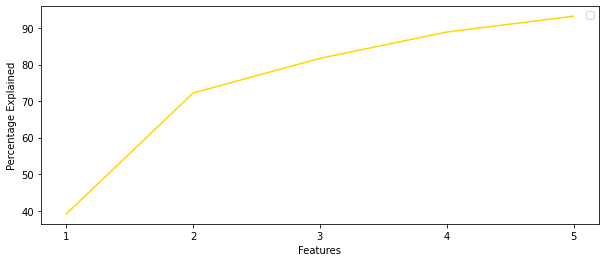

In [51]:
from matplotlib.ticker import MaxNLocator
ncomps = 5
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(scaled_df)
plt_data = pd.DataFrame(svd_fit.explained_variance_ratio_.cumsum()*100)
plt_data.index = np.arange(1, len(plt_data) + 1)
Y_pred = svd.fit_transform(scaled_df)
ax = plt_data.plot(kind = 'line', figsize = (10, 4), color = 'gold')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Features")
ax.set_ylabel("Percentage Explained")
ax.legend("")
print('Five most important components of machine learning model == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In the above graph we see that approximately 93% of the data variance can be defined in only 5 variables.

In [52]:
df_svd = pd.DataFrame(Y_pred, columns = ['columns {}'.format(c) for c in range(ncomps)], index = scaled_df.index)
print(df_svd.shape)
df_svd.head()

(8000, 5)


,columns 0,columns 1,columns 2,columns 3,columns 4
timestamp,,,,,
2022-01-09 15:00:00+00:00,0.091793,1.652847,1.323194,-0.349389,-1.317786
2022-04-21 21:00:00+00:00,2.121551,3.462025,-2.384879,0.383880,-0.633532
2022-01-04 09:00:00+00:00,-0.851370,2.197781,1.717784,-1.236547,-0.045920
2022-02-19 08:00:00+00:00,0.615203,1.935065,1.186936,-1.347810,-0.405308
2022-07-26 18:00:00+00:00,4.372927,-0.053073,0.661335,-1.175209,0.423622


#### Visualizing the compressed data 

##### Pairs Plots 
Pairs-plots are a simple representation using a set of 2D scatterplots, plotting each component against another component, and coloring the datapoints according to their classification (or type of signal).

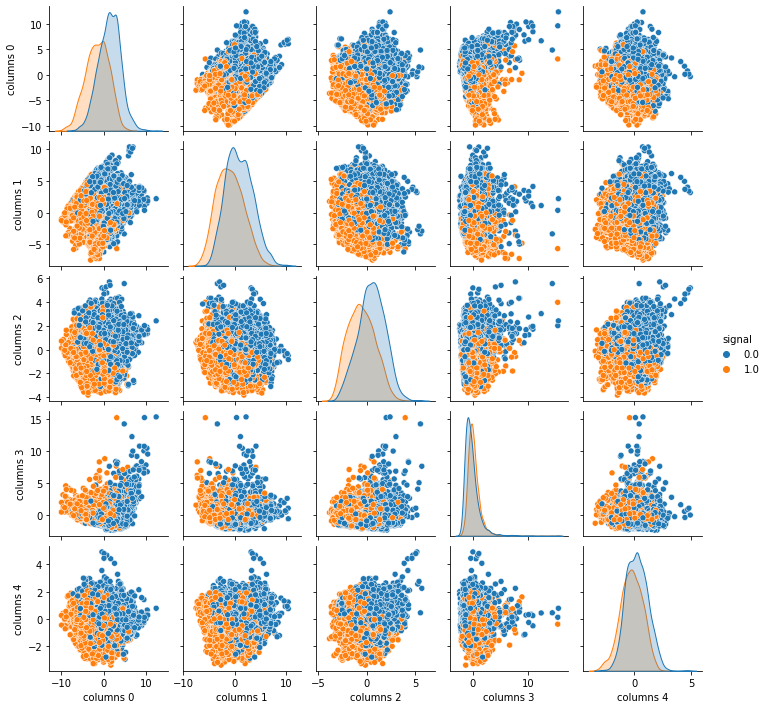

In [55]:
import matplotlib.pyplot as plt
svd_columns = [c for c in df_svd.columns if c[0] == 'c']
plot_dims = 5
ploteo_rows = 1
df_svd_plot = df_svd[svd_columns].iloc[:,:plot_dims]
df_svd_plot['signal']=Y_train
ax = sns.pairplot(df_svd_plot.iloc[::ploteo_rows,:], hue = 'signal', size = 2)


In the above graphs we can see that the data clusters are clear and segregated which indicates the data is being clustered with other like information. 

#### 3D Scatterplot

As an alternative to the pairs-plots, we could view a 3D scatterplot, which helps us see the dimensions in more ways while also being really cool to look at. 

In [56]:
def scatter_3D(A, elevation = 30, azimuth = 120):
    
    maxpts = 1000
    fig = plt.figure(1, figsize = (10, 10))
    ax = Axes3D(fig, rect = [0, 0, .95, 1], elev = elevation, azim = azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace = False))
    coloridx = np.unique(A.iloc[rndpts]['signal'], return_inverse = True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c = colors, cmap = "jet", marker = 'o', alpha = .5
               ,s = 50, linewidths = 2, edgecolor ='#CCCCCC')

    plt.show()

In [57]:
df_svd['signal'] = Y_train
interactive(scatter_3D, A = fixed(df_svd), elevation = 30, azimuth = 120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

#### t-SNE visualization
In this step, we implement another technique of dimensionality reduction - t-SNE and look at the related visualization.

In [58]:
#Visualization of Reduced Features
#Visualize the data with the compressed dataset, represented by the top 5 components of an SVD.
tsne = TSNE(n_components=2, random_state=0)

In [60]:
Z = tsne.fit_transform(df_svd[svd_columns])
tsne_data = pd.DataFrame(Z, columns = ['x','y'], index = df_svd.index)
tsne_data['signal'] = Y_train

Text(0.5, 1.0, 'Scatter of a multiple dimension data in 2D')

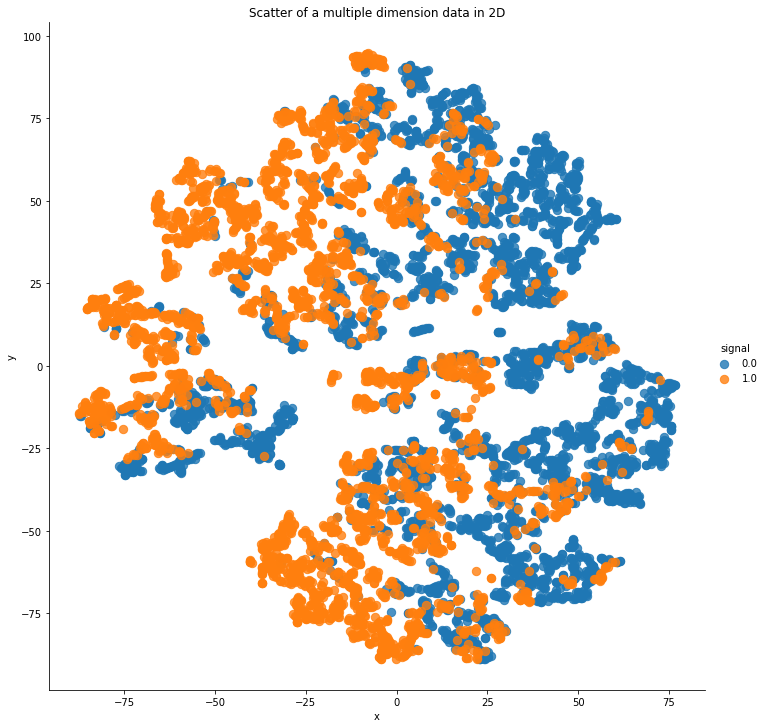

In [61]:
g = sns.lmplot('x', 'y', tsne_data, hue = 'signal', fit_reg = False, size = 10
                ,scatter_kws = {'alpha':0.8,'s':70,})
g.axes.flat[0].set_title('Scatter of a multiple dimension data in 2D')

The graph above outlines data reduced to 2-D through tsne dimensionality reduction.  We can see a good amount of clustering for our buy and sell signals and determine that the tsne reduction captures the essence of the model accurately. 

In [62]:
import time
start_time = time.time()

In [63]:
# spot check the algorithms by building a random forest classifier model
rf_models =  RandomForestClassifier(n_jobs = -1)

In [64]:
# identify kfold validation sets
kfold = KFold(n_splits = number_folds)

In [65]:
# Cross examination results
cv_results_XTrain = cross_val_score(ml_model, X_train, Y_train, cv=kfold, scoring=scoring)

In [66]:
# Print the results
print("Processing time in seconds without SVD dimensionality reduction  %s seconds" % (time.time() - start_time))

Processing time in seconds without SVD dimensionality reduction  22.7678382396698 seconds


In [68]:
start_time = time.time()
X_SVD= df_svd[svd_columns].iloc[:,:5]
cv_results_SVD = cross_val_score(ml_model, X_SVD, Y_train, cv=kfold, scoring=scoring)
print("Processing time in seconds with SVD dimensionality reduction %s seconds" % (time.time() - start_time))

Processing time in seconds with SVD dimensionality reduction 3.3433825969696045 seconds


In [69]:
print("Accuracy without SVD dimensionality reduction factors: %f (%f)" % (cv_results_XTrain.mean(), cv_results_XTrain.std()))
print("Accuracy with SVD dimesnionality reduction factors: %f (%f)" % (cv_results_SVD.mean(), cv_results_SVD.std()))

Accuracy without SVD dimensionality reduction factors: 0.939750 (0.006490)
Accuracy with SVD dimesnionality reduction factors: 0.899125 (0.009455)


#### Our Conclusions

Looking at the data above we can see that the accuracy of model when using dimensionality reduction is reduced by around 4% but it is also almost twice as fast.  Due to the fact that the accuracy is still very high it is clear that reducing the dimensionality would benefit a trader as time is of the essence when executing trades at this speed.